---

## Table of Contents
[Project description](#Description)  
[Introduction](#Introduction)  
[Exploratory Data Analysis](#EDA)  
[Model fit to training data, checking assumptions](#Model_fit)  
[Hypothesis tests](#Hyp_tests)  
[Using the model for prediction](#Prediction)  
[Comparing to other candidate models](#Compare) 
[Discussion](#Discussion)


[Visualizing appropriate transformations](#Transformations)  
[Other candidate models](#Other_models)

---

<a id="Introduction"></a>
# Introduction
    
This analysis aims to predict Vancouver housing prices with related factors ranging from 2019 to early 2020 based on one sample data set. So that the realtors could have an overview of the real estate market in Vancouver, and sellers and potential buyers would receive proper information to make a wise decision.

To make the prediction, I adopt a statistical methodology – multivariable linear regression – to combine different factors together and make sure the accuracy of my prediction. The data I use is collected from Vancouver homes with sale prices of at most 3 million CAD from 2019 to early 2020, before any impacts of the pandemic. As is shown in Mortgage Sandbox 1
, the housing price from 2019 to early 2020 is relatively stable. Therefore, my prediction can eliminate the time series effect based on such a data set because the housing price data I have in the early stage will not have big differences from the data in the later stage. In the given data, I split 1042 data as a training set and set the rest as a testing set. I choose four variables – days on the market, total floor area, age of the house, and lot size – as my candidate variables.

There are some benefits of making this prediction. As is shown in ApartmentBlocks’s 2019 report 2, there is one policy recession in the real estate market in Vancouver from 2018 to 2019, which may cause buyers and sellers to lose confidence in the market. Therefore, the predicting model is so important that sellers in Vancouver could have a clearer sense of setting reasonable prices, to gain greater success, and potential buyers can also expect a price range for their specific conditions when purchasing houses.

Reference:
1. 	Mortgage Sandbox. (2019). Metro Vancouver. *Real Estate Trends and Price Forecast*. https://www.mortgagesandbox.com/vancouver-real-estate-forecast.
2. 	ApartmentBlocks. (2019). *Metro Vancouver's First Ever Policy-Induced Housing Recession*. https://www.apartmentblocks.ca/aptb-wp/wp-content/uploads/2019/12/Report_ApartmentBlocksYearEnd_2019_web.pdf

---

In [2]:
# Import the data:
mydata <- read.csv(file="House sale data Vancouver.csv", header=TRUE)

---
*The dataset includes the following variables:*
- Number: if your observations get out of order, please sort by Number to get them back in the correct order so that everyone will work with the same training set and validation set.
- Address: Address of the house.
- List.Date: The date that the house was listed for sale.
- Price: The final sale price of the house (\\$ CAD). Note that this may differ from what the original asking price was.
- Days.on.market: how many days the house was on the market before it sold.
- Total.floor.area: the total area in square feet of the finished living space, including kitchen, bathrooms, living room, bedrooms, etc. on all floors of the house
- Year.Built: the year when the house was built.
- Age: calculated from Year.Built to represent the house age around the time of sale.
- Lot.size: the size of the lot in square feet. This includes the area of the footprint of the house, and the area of any yard or garden.
---

In [3]:
# Create a training set and a validation set using the following code
# This will divide the dataset into ~80% training set (1042 observations)
# and ~ 20% validation set (260 observations)

# DO NOT MODIFY THIS CODE!

mydata.train <- mydata[1:1042,]
mydata.valid <- mydata[1043:nrow(mydata),]

---
<a id="EDA"></a>
# Exploratory data analysis


In [4]:
library('ggplot2')
library('plyr')
library('dplyr')
library('lattice')
library('survival')
library('Formula')
library('Hmisc')
library('car')
options(scipen=999)


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:plyr':

    is.discrete, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode




In [5]:
# Evaluate the linear association of Price vs. four variables
print('the linear association of Price vs. Days.on.market')
cor(mydata.train$Days.on.market, mydata.train$Price)
print('the linear association of Price vs. Total.floor.area')
cor(mydata.train$Total.floor.area, mydata.train$Price)
print('the linear association of Price vs. Age')
cor(mydata.train$Age, mydata.train$Price)
print('the linear association of Price vs. Lot.Size')
cor(mydata.train$Lot.Size, mydata.train$Price)

[1] "the linear association of Price vs. Days.on.market"


[1] 0.00348401

[1] "the linear association of Price vs. Total.floor.area"


[1] 0.5850913

[1] "the linear association of Price vs. Age"


[1] -0.2365744

[1] "the linear association of Price vs. Lot.Size"


[1] 0.4041716

In [6]:
# find 4 variables outliers: 

# Use value of Days.on.market to identify outliers, because the correlation of Price vs. Days.on.market is close to 0.
mydata.train$Days_outliers <- ifelse(
    (mydata.train$Days.on.market < quantile(mydata.train$Days.on.market,0.25) - 1.5 * IQR(mydata.train$Days.on.market)) | 
    (mydata.train$Days.on.market > quantile(mydata.train$Days.on.market,0.75) + 1.5 * IQR(mydata.train$Days.on.market)),  1,0)

# Use residuals of linear regression of Price vs. Total.floor.area to identify outliers, because its correlation isn't close to 0.
z.Total.floor.area <- lm(mydata.train$Price ~ mydata.train$Total.floor.area)
mydata.train$resid.Total.floor.area <- resid(z.Total.floor.area)
mydata.train$Floor_outliers <- ifelse(
    (mydata.train$resid.Total.floor.area < quantile(mydata.train$resid.Total.floor.area,0.25) - 1.5 * IQR(mydata.train$resid.Total.floor.area)) | 
    (mydata.train$resid.Total.floor.area > quantile(mydata.train$resid.Total.floor.area,0.75) + 1.5 * IQR(mydata.train$resid.Total.floor.area)),  1,0)

# Use residuals of linear regression of Price vs. Age to identify outliers, because its correlation isn't close to 0.
z.Age <- lm(mydata.train$Price ~ mydata.train$Age)
mydata.train$resid.Age <- resid(z.Age)
mydata.train$Age_outliers <- ifelse(
    (mydata.train$resid.Age < quantile(mydata.train$resid.Age,0.25) - 0.5 * IQR(mydata.train$resid.Age)) | 
    (mydata.train$resid.Age > quantile(mydata.train$resid.Age,0.75) + 0.5 * IQR(mydata.train$resid.Age)),  1,0)

# Use residuals of linear regression of Price vs. Lot.Size to identify outliers, because its correlation isn't close to 0.
z.Lot.Size <- lm(mydata.train$Price ~ mydata.train$Lot.Size)
mydata.train$resid.Lot.Size <- resid(z.Lot.Size)
mydata.train$Lot_outliers <- ifelse(
    (mydata.train$resid.Lot.Size < quantile(mydata.train$resid.Lot.Size,0.25) - 0.5 * IQR(mydata.train$resid.Lot.Size)) | 
    (mydata.train$resid.Lot.Size > quantile(mydata.train$resid.Lot.Size,0.75) + 0.5 * IQR(mydata.train$resid.Lot.Size)),  1,0)

for (i in c('Days_outliers','Floor_outliers','Age_outliers','Lot_outliers')){
    mydata.train[,i]  <- as.factor((mydata.train[,i]))
}

In [7]:
# Compare the linear association of Price vs. four variable before & after removing outliers
print('the linear association of Price vs. Days.on.market BEFORE removing outliers')
cor(mydata.train$Days.on.market, mydata.train$Price)
print('the linear association of Price vs. Days.on.market AFTER removing outliers')
mydata_rv_Days_outliers <- mydata.train %>% filter(mydata.train$Days_outliers != 1)
cor(mydata_rv_Days_outliers$Days.on.market, mydata_rv_Days_outliers$Price)

print('the linear association of Price vs. Total.floor.area BEFORE removing outliers')
cor(mydata.train$Total.floor.area, mydata.train$Price)
print('the linear association of Price vs. Total.floor.area AFTER removing outliers')
mydata_rv_floor_outliers <- mydata.train %>% filter(mydata.train$Floor_outliers != 1)
cor(mydata_rv_floor_outliers$Total.floor.area, mydata_rv_floor_outliers$Price) 

print('the linear association of Price vs. Age BEFORE removing outliers')
cor(mydata.train$Age, mydata.train$Price)
print('the linear association of Price vs. Age AFTER removing outliers')
mydata_rv_age_outliers <- mydata.train %>% filter(mydata.train$Age_outliers != 1)
cor(mydata_rv_age_outliers$Age, mydata_rv_age_outliers$Price) 

print('the linear association of Price vs. Lot.Size BEFORE removing outliers')
cor(mydata.train$Lot.Size, mydata.train$Price)
print('the linear association of Price vs. Lot.Size AFTER removing outliers')
mydata_rv_lot_outliers <- mydata.train %>% filter(mydata.train$Lot_outliers != 1)
cor(mydata_rv_lot_outliers$Lot.Size, mydata_rv_lot_outliers$Price)

[1] "the linear association of Price vs. Days.on.market BEFORE removing outliers"


[1] 0.00348401

[1] "the linear association of Price vs. Days.on.market AFTER removing outliers"


[1] 0.03605179

[1] "the linear association of Price vs. Total.floor.area BEFORE removing outliers"


[1] 0.5850913

[1] "the linear association of Price vs. Total.floor.area AFTER removing outliers"


[1] 0.6198545

[1] "the linear association of Price vs. Age BEFORE removing outliers"


[1] -0.2365744

[1] "the linear association of Price vs. Age AFTER removing outliers"


[1] -0.3722382

[1] "the linear association of Price vs. Lot.Size BEFORE removing outliers"


[1] 0.4041716

[1] "the linear association of Price vs. Lot.Size AFTER removing outliers"


[1] 0.4968214

## The scatterplot of Price vs. Days on market


Call:
lm(formula = mydata.train$Price ~ mydata.train$Days.on.market)

Residuals:
     Min       1Q   Median       3Q      Max 
-1074817  -433250  -151314   424033  1229301 

Coefficients:
                              Estimate Std. Error t value            Pr(>|t|)
(Intercept)                 1770576.03   20272.06  87.341 <0.0000000000000002
mydata.train$Days.on.market      30.73     273.49   0.112               0.911
                               
(Intercept)                 ***
mydata.train$Days.on.market    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 538700 on 1040 degrees of freedom
Multiple R-squared:  1.214e-05,	Adjusted R-squared:  -0.0009494 
F-statistic: 0.01262 on 1 and 1040 DF,  p-value: 0.9106


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


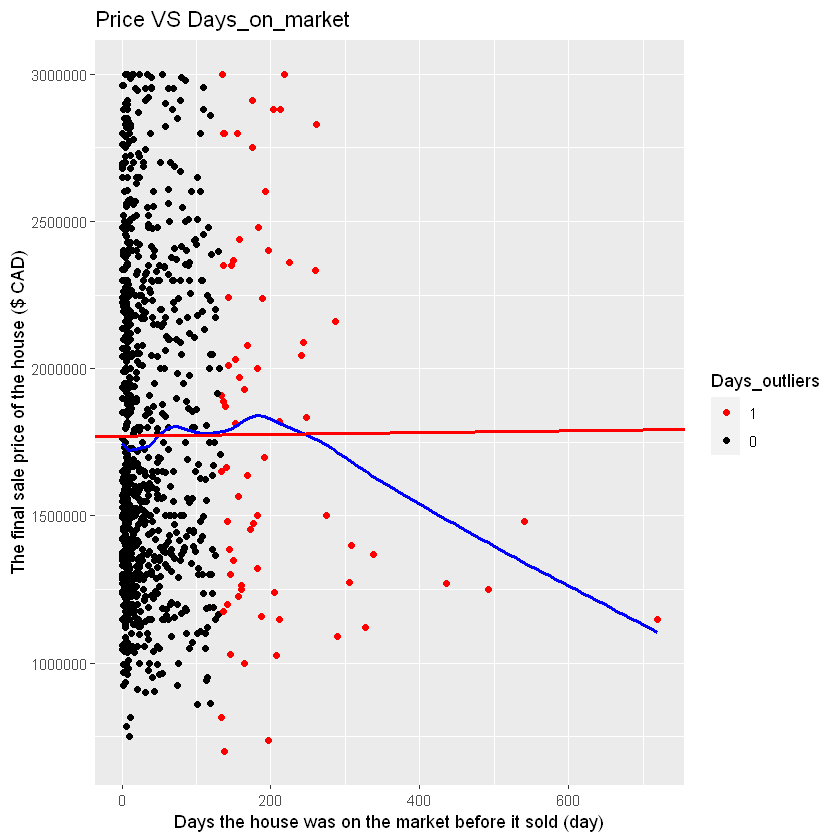

In [8]:
# BEFORE removing outliers

# Use linear regression to check the association of Price vs. Days on market
z.Days_on_market <- lm(mydata.train$Price ~ mydata.train$Days.on.market)
summary(z.Days_on_market)
# Draw a scatter plot to visualize the relationship of Price vs. Days on market
ggplot(mydata.train, aes(Days.on.market, Price))+
geom_point(aes(color=Days_outliers))+
scale_color_manual(values=c("1"="red", "0"="black"))+
stat_plsmo(span=0.4,color="blue") + # add lowess line
labs(title = "Price VS Days_on_market", # add labels
     x = "Days the house was on the market before it sold (day)", 
     y = "The final sale price of the house ($ CAD)")+
geom_abline(aes(intercept=1770576.03,slope= 30.73),col='red',lwd = 1) #intercept & slope are from linear regression


Call:
lm(formula = mydata_rv_Days_outliers$Price ~ mydata_rv_Days_outliers$Days.on.market)

Residuals:
     Min       1Q   Median       3Q      Max 
-1008070  -423332  -152595   419614  1245405 

Coefficients:
                                        Estimate Std. Error t value
(Intercept)                            1752279.1    22977.6  76.260
mydata_rv_Days_outliers$Days.on.market     579.0      516.2   1.122
                                                  Pr(>|t|)    
(Intercept)                            <0.0000000000000002 ***
mydata_rv_Days_outliers$Days.on.market               0.262    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 531800 on 967 degrees of freedom
Multiple R-squared:  0.0013,	Adjusted R-squared:  0.0002669 
F-statistic: 1.258 on 1 and 967 DF,  p-value: 0.2622


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


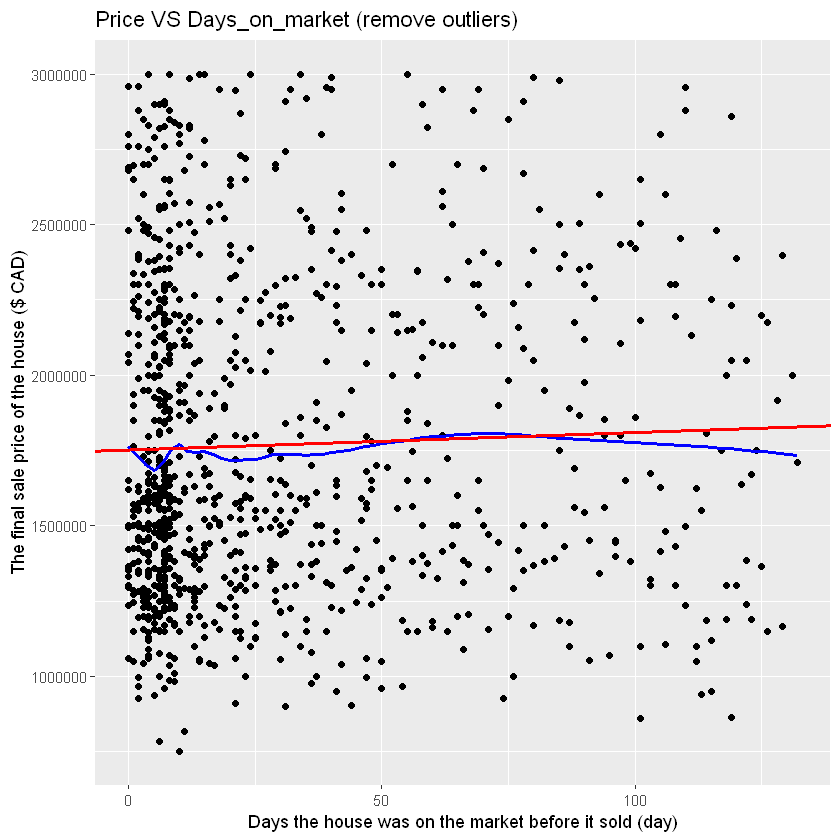

In [9]:
# After removing outliers

# Use linear regression to check the association of Price vs. Days on market after removing outliers
z.Days_on_market_rv <- lm(mydata_rv_Days_outliers$Price ~ mydata_rv_Days_outliers$Days.on.market)
summary(z.Days_on_market_rv)
# Draw a scatter plot to visualize the relationship of Price vs. Days on market after removing outliers
ggplot(mydata_rv_Days_outliers, aes(Days.on.market, Price))+
geom_point()+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Days_on_market (remove outliers)",
     x = "Days the house was on the market before it sold (day)", 
     y = "The final sale price of the house ($ CAD)") +
geom_abline(aes(intercept=1752279.1,slope= 579.0),col='red',lwd = 1)

## The scatterplot of Price vs. Total floor area


Call:
lm(formula = mydata.train$Price ~ mydata.train$Total.floor.area)

Residuals:
     Min       1Q   Median       3Q      Max 
-1244927  -309103  -101646   263813  1902266 

Coefficients:
                               Estimate Std. Error t value            Pr(>|t|)
(Intercept)                   664598.73   49477.04   13.43 <0.0000000000000002
mydata.train$Total.floor.area    451.14      19.39   23.27 <0.0000000000000002
                                 
(Intercept)                   ***
mydata.train$Total.floor.area ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 436900 on 1040 degrees of freedom
Multiple R-squared:  0.3423,	Adjusted R-squared:  0.3417 
F-statistic: 541.3 on 1 and 1040 DF,  p-value: < 0.00000000000000022


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


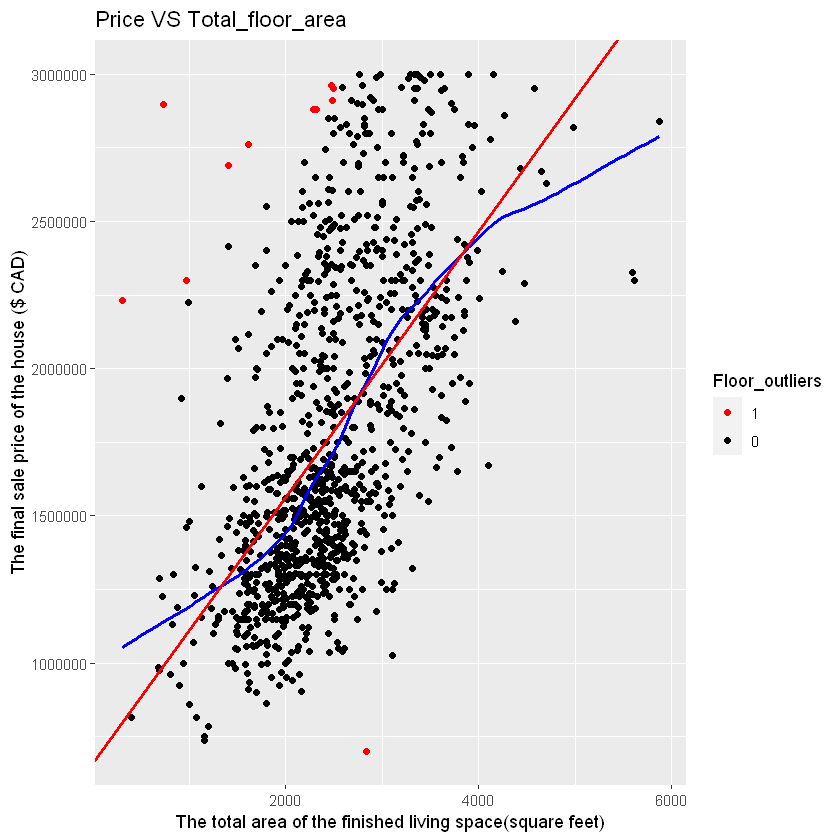

In [10]:
# BEFORE removing outliers

# Use linear regression to check the association of Price vs. Total.floor.area
z.Total.floor.area <- lm(mydata.train$Price ~ mydata.train$Total.floor.area)
summary(z.Total.floor.area)
# Draw a scatter plot to visualize the relationship of Price vs. Total.floor.area 
ggplot(mydata.train, aes(Total.floor.area, Price))+
geom_point(aes(color=Floor_outliers))+
scale_color_manual(values=c("1"="red", "0"="black"))+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Total_floor_area",
     x = "The total area of the finished living space(square feet)", 
     y = "The final sale price of the house ($ CAD)")+
geom_abline(aes(intercept=664598.73,slope= 451.14),col='red',,lwd = 1) #intercept & slope are from linear regression


Call:
lm(formula = mydata_rv_floor_outliers$Price ~ mydata_rv_floor_outliers$Total.floor.area)

Residuals:
     Min       1Q   Median       3Q      Max 
-1045299  -294267   -91813   263404  1159934 

Coefficients:
                                           Estimate Std. Error t value
(Intercept)                               595743.74   47878.61   12.44
mydata_rv_floor_outliers$Total.floor.area    474.44      18.72   25.34
                                                     Pr(>|t|)    
(Intercept)                               <0.0000000000000002 ***
mydata_rv_floor_outliers$Total.floor.area <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 416900 on 1029 degrees of freedom
Multiple R-squared:  0.3842,	Adjusted R-squared:  0.3836 
F-statistic: 642.1 on 1 and 1029 DF,  p-value: < 0.00000000000000022


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


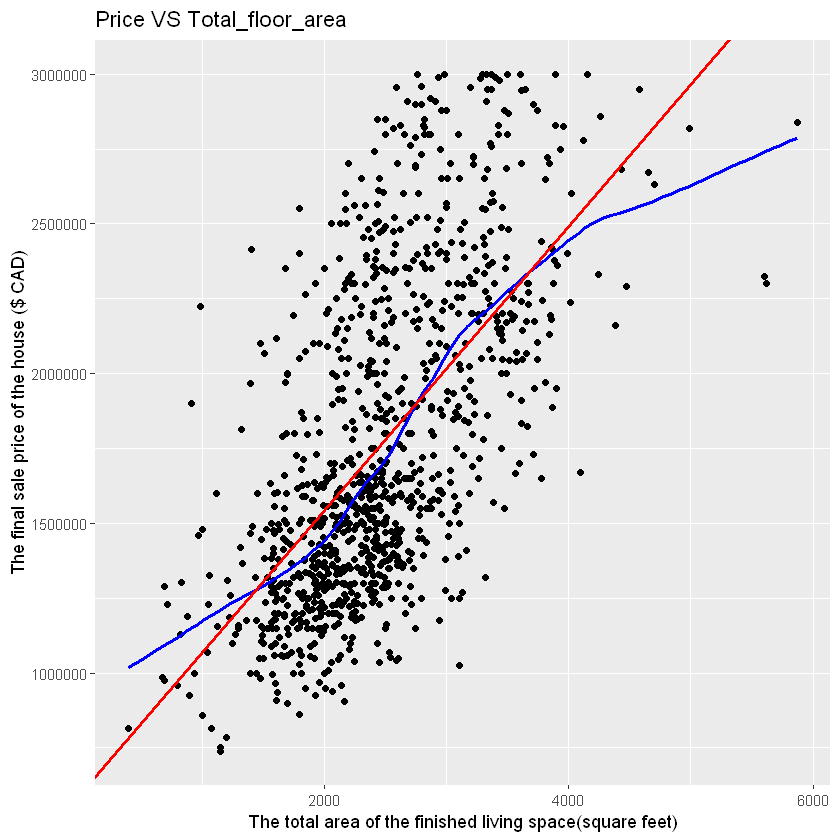

In [11]:
# AFTER removing outliers

# Use linear regression to check the association of Price vs. Total floor area after removing outliers
z.Total_floor_area_rv <- lm(mydata_rv_floor_outliers$Price ~ mydata_rv_floor_outliers$Total.floor.area)
summary(z.Total_floor_area_rv)
# Draw a scatter plot to visualize the relationship of Price vs. Total.floor.area after removing outliers
ggplot(mydata_rv_floor_outliers, aes(Total.floor.area, Price))+
geom_point()+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Total_floor_area",
     x = "The total area of the finished living space(square feet)", 
     y = "The final sale price of the house ($ CAD)") +
geom_abline(aes(intercept=595743.74,slope= 474.44),col='red',lwd = 1) #intercept & slope are from linear regression

## The scatterplot of Price vs. Age


Call:
lm(formula = mydata.train$Price ~ mydata.train$Age)

Residuals:
     Min       1Q   Median       3Q      Max 
-1091693  -422510  -153732   363475  1391758 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)       1987636      31906  62.297 < 0.0000000000000002 ***
mydata.train$Age    -3698        471  -7.852   0.0000000000000101 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 523400 on 1040 degrees of freedom
Multiple R-squared:  0.05597,	Adjusted R-squared:  0.05506 
F-statistic: 61.66 on 1 and 1040 DF,  p-value: 0.00000000000001013


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


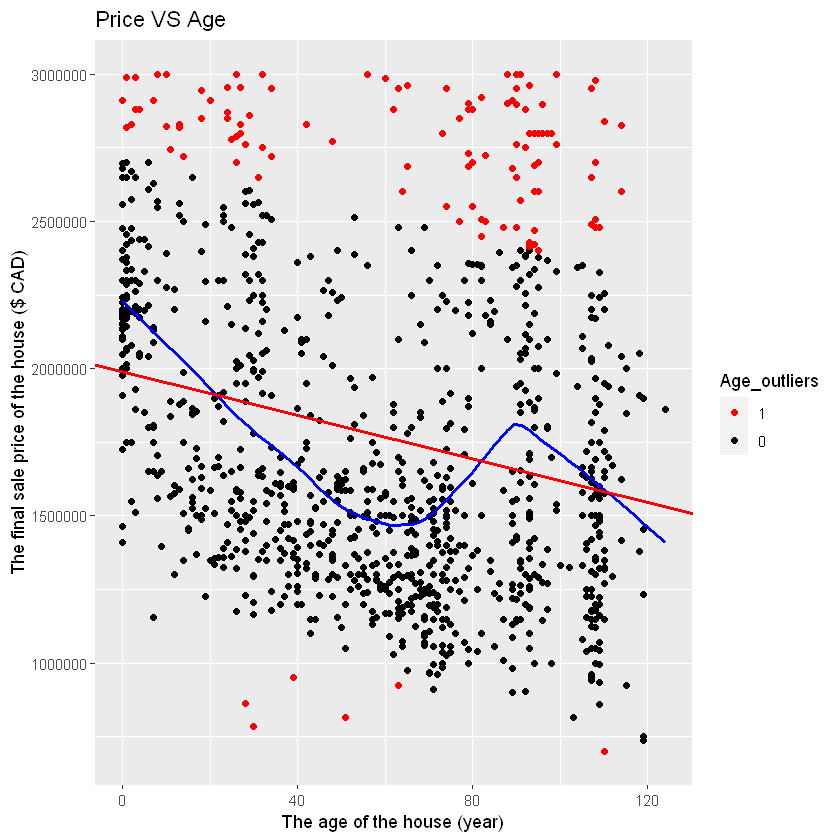

In [12]:
# BEFORE removing outliers

# Use linear regression to check the association of Price vs. Age 
z.Age <- lm(mydata.train$Price ~ mydata.train$Age)
summary(z.Age)
# Draw a scatter plot to visualize the relationship of Price vs. Age
ggplot(mydata.train, aes(Age, Price))+
geom_point(aes(color=Age_outliers))+
scale_color_manual(values=c("1"="red", "0"="black"))+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Age",
     x = "The age of the house (year)", 
     y = "The final sale price of the house ($ CAD)")+
geom_abline(aes(intercept=1987636,slope= -3698),col='red',lwd = 1) #intercept & slope are from linear regression


Call:
lm(formula = mydata_rv_age_outliers$Price ~ mydata_rv_age_outliers$Age)

Residuals:
    Min      1Q  Median      3Q     Max 
-744882 -329274  -95452  293686  911578 

Coefficients:
                            Estimate Std. Error t value            Pr(>|t|)    
(Intercept)                1932843.5    25851.8   74.77 <0.0000000000000002 ***
mydata_rv_age_outliers$Age   -4708.8      385.8  -12.20 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 402700 on 926 degrees of freedom
Multiple R-squared:  0.1386,	Adjusted R-squared:  0.1376 
F-statistic: 148.9 on 1 and 926 DF,  p-value: < 0.00000000000000022


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


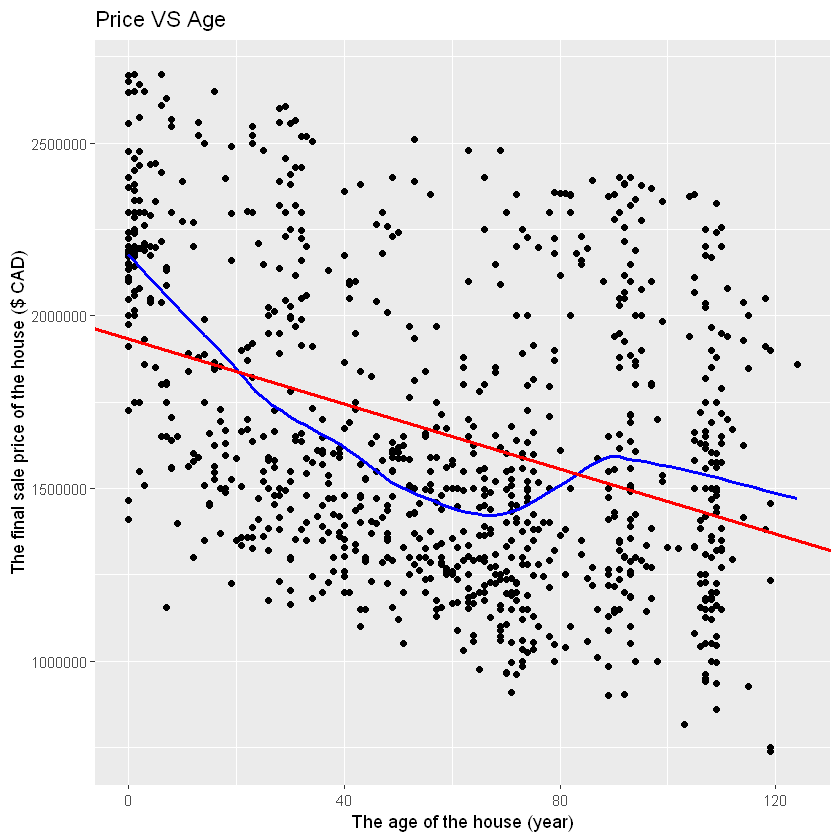

In [13]:
# AFTER removing outliers

# Use linear regression to check the association of Price vs. Age after removing outliers
z.Age_rv <- lm(mydata_rv_age_outliers$Price ~ mydata_rv_age_outliers$Age)
summary(z.Age_rv)
# Draw a scatter plot to visualize the relationship of Price vs. Age after removing outliers
ggplot(mydata_rv_age_outliers, aes(Age, Price))+
geom_point()+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Age",
     x = "The age of the house (year)", 
     y = "The final sale price of the house ($ CAD)") +
geom_abline(aes(intercept=1932843.5,slope= -4708.8),col='red',lwd = 1) #intercept & slope are from linear regression

## The scatterplot of Price vs. Lot size


Call:
lm(formula = mydata.train$Price ~ mydata.train$Lot.Size)

Residuals:
     Min       1Q   Median       3Q      Max 
-1470676  -396711  -122121   396383  1288955 

Coefficients:
                        Estimate Std. Error t value            Pr(>|t|)    
(Intercept)           1033898.75   53990.50   19.15 <0.0000000000000002 ***
mydata.train$Lot.Size     168.83      11.85   14.25 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 492700 on 1040 degrees of freedom
Multiple R-squared:  0.1634,	Adjusted R-squared:  0.1626 
F-statistic: 203.1 on 1 and 1040 DF,  p-value: < 0.00000000000000022


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


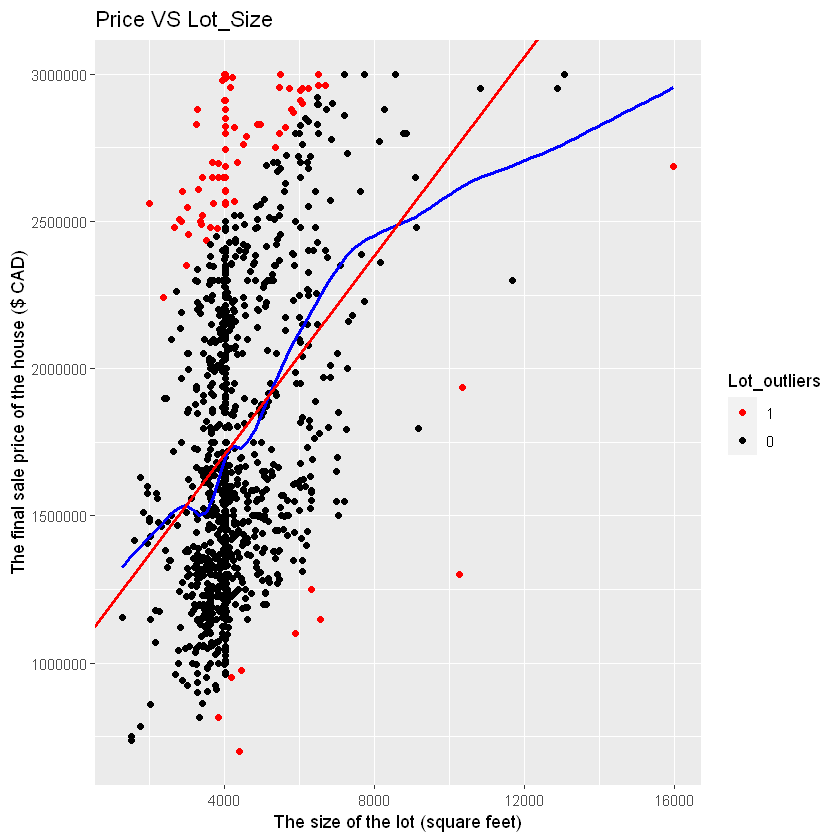

In [14]:
# BEFORE removing outliers

# Use linear regression to check the association of Price vs. Lot size
z.Lot.Size <- lm(mydata.train$Price ~ mydata.train$Lot.Size)
summary(z.Lot.Size)
# Draw a scatter plot to visualize the relationship of Price vs. Lot size
ggplot(mydata.train, aes(Lot.Size, Price))+
geom_point(aes(color=Lot_outliers))+
scale_color_manual(values=c("1"="red", "0"="black"))+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Lot_Size",
     x = "The size of the lot (square feet)", 
     y = "The final sale price of the house ($ CAD)")+
geom_abline(aes(intercept=1033898.75,slope= 168.83),col='red',lwd = 1) #intercept & slope are from linear regression


Call:
lm(formula = mydata_rv_lot_outliers$Price ~ mydata_rv_lot_outliers$Lot.Size)

Residuals:
    Min      1Q  Median      3Q     Max 
-846892 -346059  -87270  370038  876267 

Coefficients:
                                 Estimate Std. Error t value
(Intercept)                     855578.99   49664.26   17.23
mydata_rv_lot_outliers$Lot.Size    194.91      11.01   17.71
                                           Pr(>|t|)    
(Intercept)                     <0.0000000000000002 ***
mydata_rv_lot_outliers$Lot.Size <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 415200 on 957 degrees of freedom
Multiple R-squared:  0.2468,	Adjusted R-squared:  0.246 
F-statistic: 313.6 on 1 and 957 DF,  p-value: < 0.00000000000000022


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


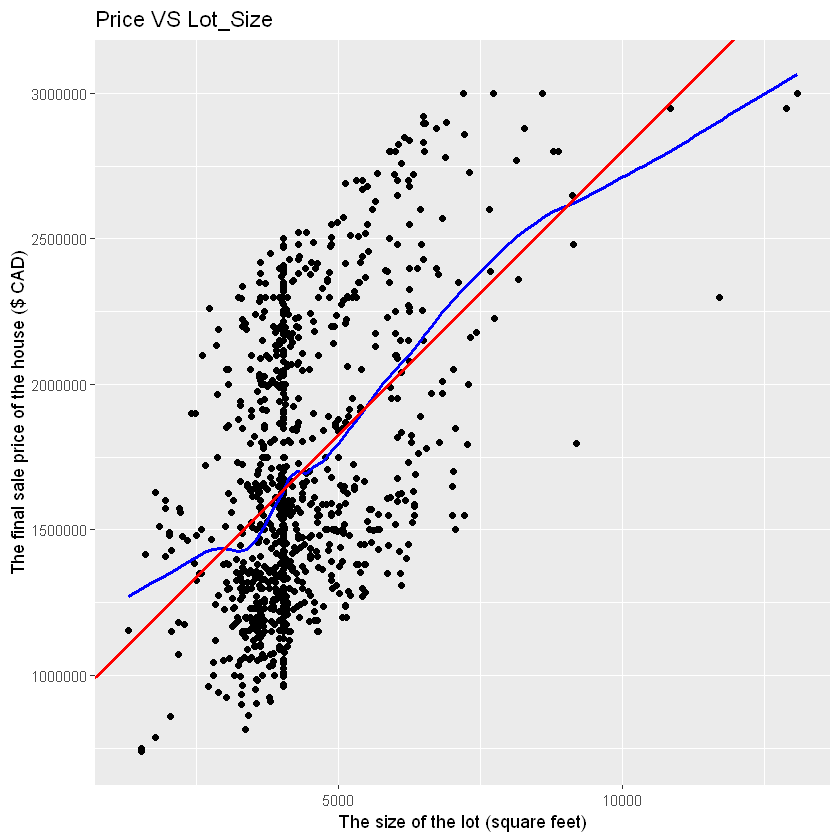

In [15]:
# AFTER removing outliers

# Use linear regression to check the association of Price vs. Lot size after removing outliers
z.Lot_size_rv <- lm(mydata_rv_lot_outliers$Price ~ mydata_rv_lot_outliers$Lot.Size)
summary(z.Lot_size_rv)
# Draw a scatter plot to visualize the relationship of Price vs. Lot size after removing outliers
ggplot(mydata_rv_lot_outliers, aes(Lot.Size, Price))+
geom_point()+
stat_plsmo(span=0.4,color="blue") +
labs(title = "Price VS Lot_Size",
     x = "The size of the lot (square feet)", 
     y = "The final sale price of the house ($ CAD)") +
geom_abline(aes(intercept=855578.99,slope= 194.91),col='red',lwd = 1) #intercept & slope are from linear regression

## Briefly describe the form, direction, strength, and any outliers.

* Association for Price vs Days on market.
    1. Form: No. It is not linear.
    2. Direction: No association.
    3. Strength: No correlation (before removing outliers: correlation = 0.003; after removing outliers: 0.036).
    4. Outliers: 73 outliers, 7.0% out of 1042 points.
    
 
    
* Association for Price vs Floor area.
    1. Form: Yes. It is linear.
    2. Direction: Positive association.
    3. Strength: Strong positive correlation (before removing outliers: correlation = 0.585; after removing outliers: 0.620).
    4. Outliers: 11 outliers, 1.1% out of 1042 points.
    
    
    
* Association for Price vs Age.
    1. Form: No. It is not linear.
    2. Direction: Negative association.
    3. Strength: Weak negative correlation (before removing outliers: correlation = -0.237; after removing outliers: -0.372).
    4. Outliers: 114 outliers, 10.9% out of 1042 points.
    
    
    
* Association for Price vs Lot size.
    1. Form: No. It is not linear.
    2. Direction: Positive association.
    3. Strength: Moderate positive correlation (before removing outliers: correlation = 0.404; after removing outliers: 0.497).
    4. Outliers: 83 outliers, 8.0% out of 1042 points. 

## Discuss outliers - what makes them unusual?

I use two different criteria to choose the outliers for the four given variables. For the variable “Days on market”, because the correlation between price and “Days on market” is close to zero, I simply mark the outliers with 1.5 IQR (InterQuartile Range), removing the value of lower than 0.25 quantiles minus 1.5 IQR and greater than 0.75 quantiles plus 1.5 IQR. As the correlations between price and other variables are not close to zero, I decide to select the outliers using the IQR methods for residuals of linear regression. I build simple linear regressions for each variable, calculate the residuals of each data, and find the outliers with the IQR method as above. However, I change the range of IQR for variables “Age” and “Lot size” to make the outliers more reasonable.

* All the outliers in the plot of Price vs **Days on market** have too large values of Days on market. The potential reason might be the website or sources we collect data from did not delete the houses that had been listed for a long time. Another possible reason is that the seller forget to mark the listings as sold, so the website may not be able to do anything with the data.



* The outliers in the plot of Price vs **Total Floor Area** and Price vs **Lot size** are far from the linear regression because most of them are in the most expensive areas in Vancouver, such as Dunbar, Toronto street, and nearby UBC campus, etc.



* The outliers in the plot of Price vs **Age** are far from the linear regression. Based on the given data, however, the trend of those outliers is not clear so it is better to not make a projection that these outliers have any specific characteristics.


---
<a id="Model_fit"></a>
# Model fit to training data, checking assumptions


In [16]:
# Add any transformations to the training dataset:
mydata.train$Days.log <- log(mydata.train$Days.on.market + 1)
mydata.train$Days.sqrt <- sqrt(mydata.train$Days.on.market + 1)
mydata.train$Days.sq <- (mydata.train$Days.on.market + 1)^2

mydata.train$Total.log <- log(mydata.train$Total.floor.area)
mydata.train$Total.sqrt <- sqrt(mydata.train$Total.floor.area)
mydata.train$Total.sq <- (mydata.train$Total.floor.area)^2

mydata.train$Age.log <- log(mydata.train$Age +1)
mydata.train$Age.sqrt <- sqrt(mydata.train$Age + 1)
mydata.train$Age.sq <- (mydata.train$Age + 1)^2

mydata.train$Lot.log <- log(mydata.train$Lot.Size)
mydata.train$Lot.sqrt <- sqrt(mydata.train$Lot.Size)
mydata.train$Lot.sq <- (mydata.train$Lot.Size)^2

I test three kinds of transformations (log, squared, squared root) of the four candidate variables by plotting them:

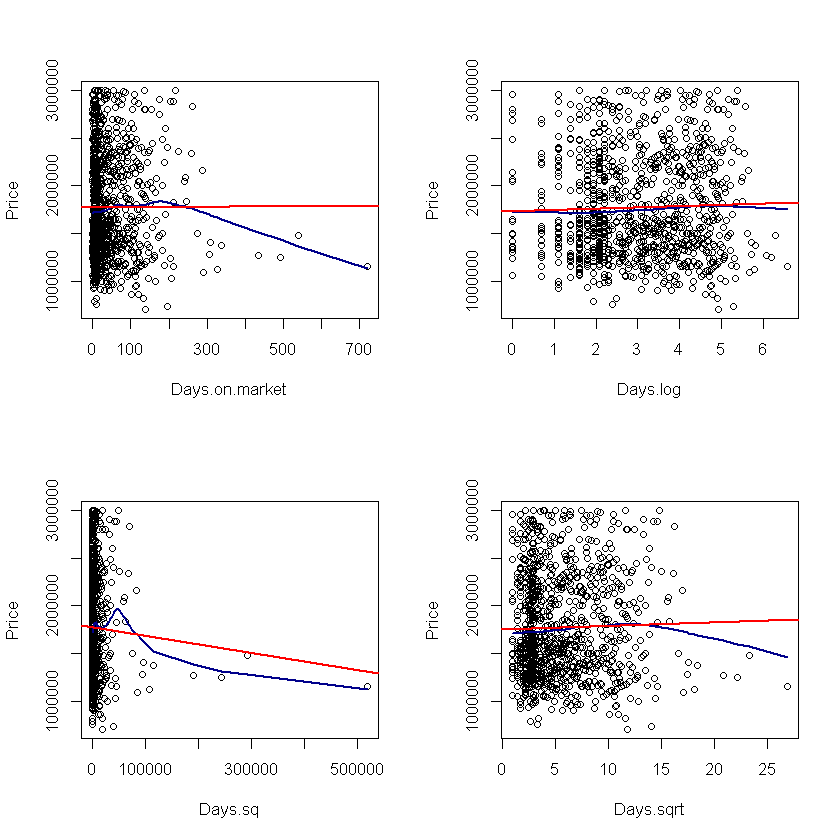

In [17]:
# Transformation: Days On Market
par(mfrow=c(2,2))

plot(Price ~ Days.on.market, data = mydata.train)
lines(lowess(mydata.train$Days.on.market, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zD <- lm(Price ~ Days.on.market, data = mydata.train)
abline(zD, col="red", lwd = 2)

plot(Price ~ Days.log, data = mydata.train)
lines(lowess(mydata.train$Days.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zDlog <- lm(Price ~ Days.log, data = mydata.train)
abline(zDlog, col="red", lwd = 2)

plot(Price ~ Days.sq, data = mydata.train)
lines(lowess(mydata.train$Days.sq, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zDsq <- lm(Price ~ Days.sq, data = mydata.train)
abline(zDsq, col="red", lwd = 2)

plot(Price ~ Days.sqrt, data = mydata.train)
lines(lowess(mydata.train$Days.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zDsqrt <- lm(Price ~ Days.sqrt, data = mydata.train)
abline(zDsqrt, col="red", lwd = 2)

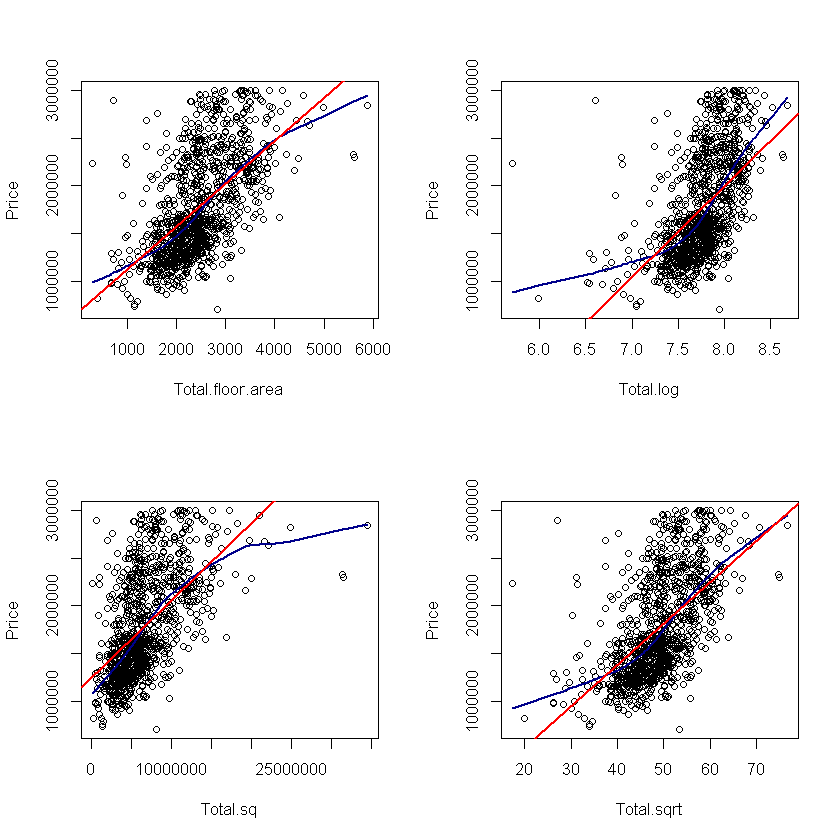

In [18]:
# Transformation: Total Floor Area
par(mfrow=c(2,2))

plot(Price ~ Total.floor.area, data = mydata.train)
lines(lowess(mydata.train$Total.floor.area, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zT <- lm(Price ~ Total.floor.area, data = mydata.train)
abline(zT, col="red", lwd = 2)

plot(Price ~ Total.log, data = mydata.train)
lines(lowess(mydata.train$Total.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zTlog <- lm(Price ~ Total.log, data = mydata.train)
abline(zTlog, col="red", lwd = 2)

plot(Price ~ Total.sq, data = mydata.train)
lines(lowess(mydata.train$Total.sq, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zTsq <- lm(Price ~ Total.sq, data = mydata.train)
abline(zTsq, col="red", lwd = 2)

plot(Price ~ Total.sqrt, data = mydata.train)
lines(lowess(mydata.train$Total.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zTsqrt <- lm(Price ~ Total.sqrt, data = mydata.train)
abline(zTsqrt, col="red", lwd = 2)

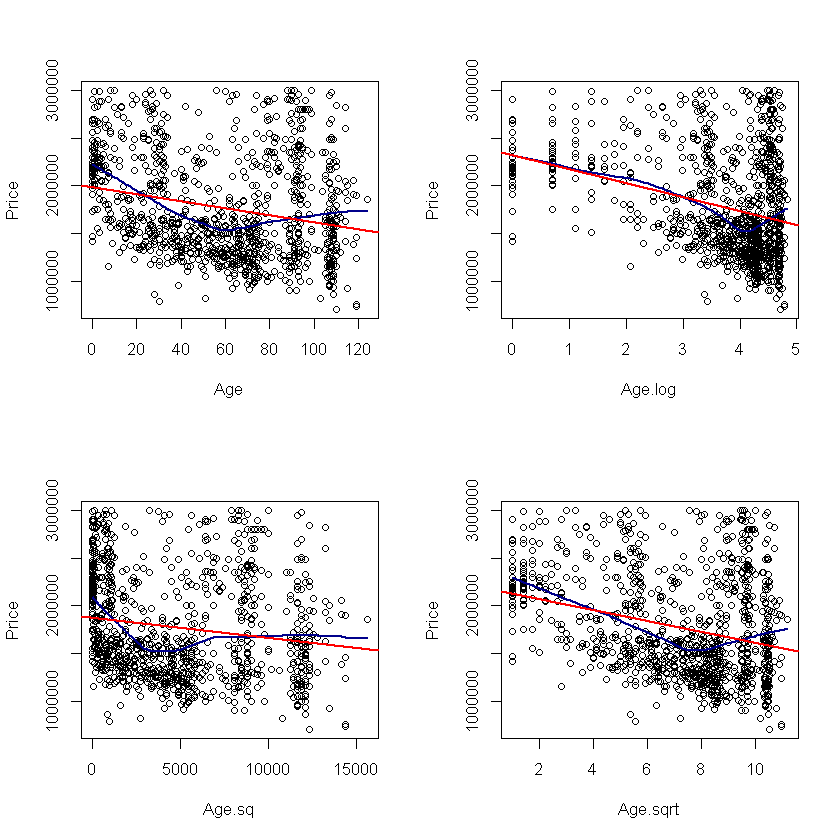

In [19]:
# Transformation: Age
par(mfrow=c(2,2))

plot(Price ~ Age, data = mydata.train)
lines(lowess(mydata.train$Age, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zA <- lm(Price ~ Age, data = mydata.train)
abline(zA, col="red", lwd = 2)

plot(Price ~ Age.log, data = mydata.train)
lines(lowess(mydata.train$Age.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zAlog <- lm(Price ~ Age.log, data = mydata.train)
abline(zAlog, col="red", lwd = 2)

plot(Price ~ Age.sq, data = mydata.train)
lines(lowess(mydata.train$Age.sq, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zAsq <- lm(Price ~ Age.sq, data = mydata.train)
abline(zAsq, col="red", lwd = 2)

plot(Price ~ Age.sqrt, data = mydata.train)
lines(lowess(mydata.train$Age.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zAsqrt <- lm(Price ~ Age.sqrt, data = mydata.train)
abline(zAsqrt, col="red", lwd = 2)

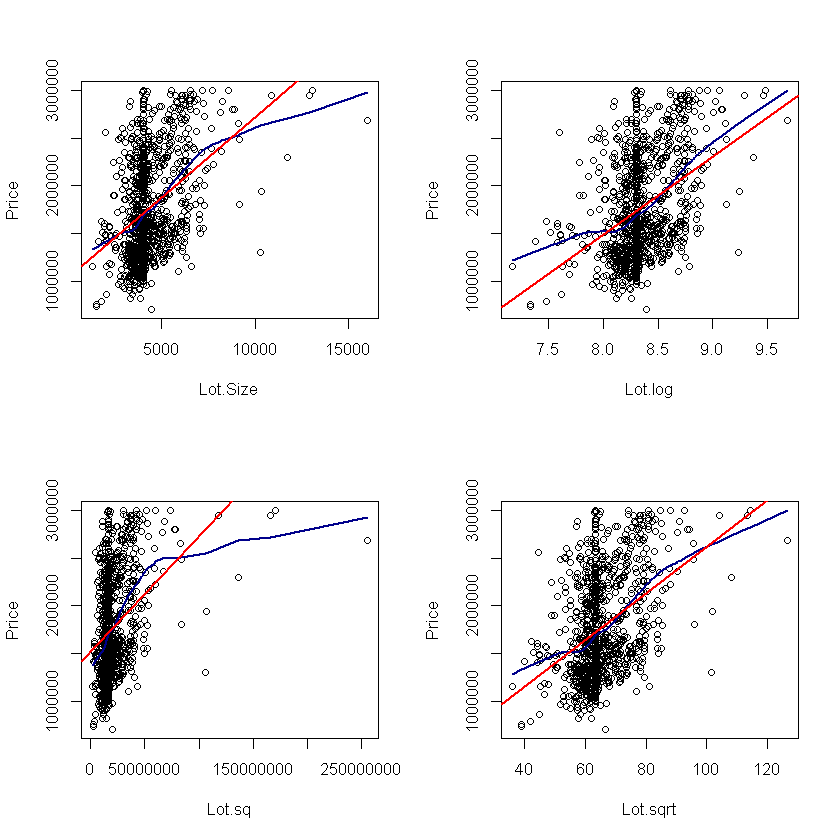

In [20]:
# Transformation: Lot Size
par(mfrow=c(2,2))

plot(Price ~ Lot.Size, data = mydata.train)
lines(lowess(mydata.train$Lot.Size, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zL <- lm(Price ~ Lot.Size, data = mydata.train)
abline(zL, col="red", lwd = 2)

plot(Price ~ Lot.log, data = mydata.train)
lines(lowess(mydata.train$Lot.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zLlog <- lm(Price ~ Lot.log, data = mydata.train)
abline(zLlog, col="red", lwd = 2)

plot(Price ~ Lot.sq, data = mydata.train)
lines(lowess(mydata.train$Lot.sq, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zLsq <- lm(Price ~ Lot.sq, data = mydata.train)
abline(zLsq, col="red", lwd = 2)

plot(Price ~ Lot.sqrt, data = mydata.train)
lines(lowess(mydata.train$Lot.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zLsqrt <- lm(Price ~ Lot.sqrt, data = mydata.train)
abline(zLsqrt, col="red", lwd = 2)

Based on the above plots, I choose what candidate variables and the transformations I would use in our model:

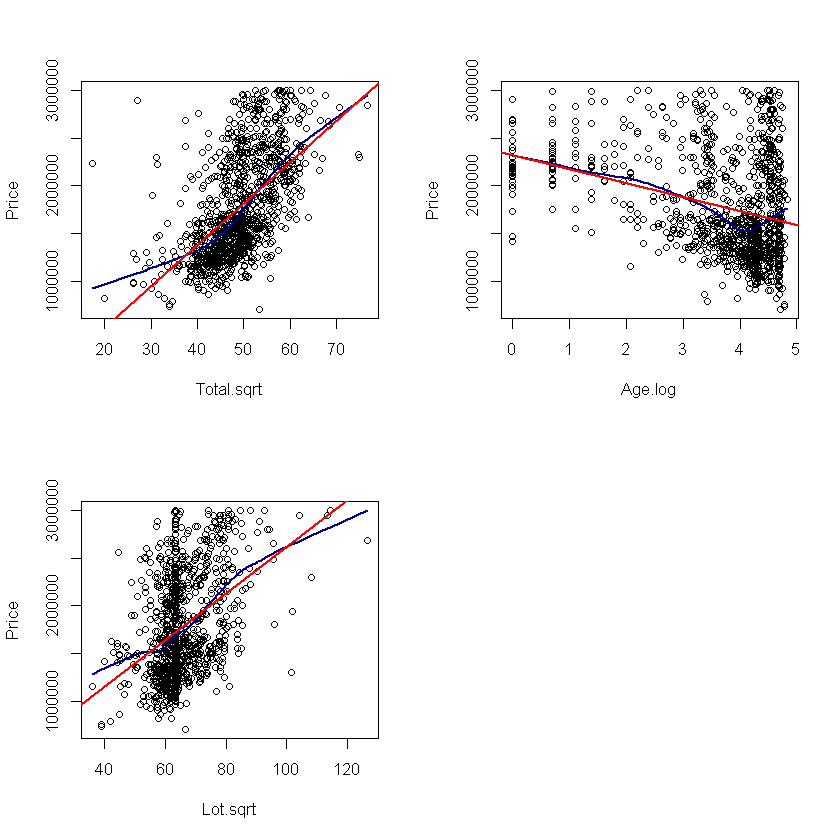

In [21]:
# Create scatterplots that visualize the association between the variables as they are used in the model:

par(mfrow=c(2,2))

plot(Price ~ Total.sqrt, data = mydata.train)
lines(lowess(mydata.train$Total.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zTsqrt <- lm(Price ~ Total.sqrt, data = mydata.train)
abline(zTsqrt, col="red", lwd = 2)

plot(Price ~ Age.log, data = mydata.train)
lines(lowess(mydata.train$Age.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zAlog <- lm(Price ~ Age.log, data = mydata.train)
abline(zAlog, col="red", lwd = 2)

plot(Price ~ Lot.sqrt, data = mydata.train)
lines(lowess(mydata.train$Lot.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zLsqrt <- lm(Price ~ Lot.sqrt, data = mydata.train)
abline(zLsqrt, col="red", lwd = 2)

And I check the correlation of these transformations we choose.

In [22]:
# Is the form linear for each of these associations after the transformations?
corrT <- cor(mydata.train$Total.sqrt, mydata.train$Price);corrT
corrL <- cor(mydata.train$Lot.sqrt, mydata.train$Price);corrL
corrA <- cor(mydata.train$Age.log, mydata.train$Price);corrA

[1] 0.5744366

[1] 0.4092818

[1] -0.3144219

**Is the form linear for each of these associations after the transformations?**

Based on the graphs before and after transformation for each variable, the Days on Market variable has no association with the Price, while the rest are linear.

* **Days on Market**: We drop it because it shows no association with the Price in each plot, or we can say the Days on Market variable doesn't perform well on both before and after transformation plots. Although the log of Days on Market has closest lowess line and linear regression line, the scatter plots is too disperse to say there is any association between Days on market and Price. With the reason above, the final model will exclude this variable into consideration.

* **Total floor area & Lot size**: We choose the square root transformation because they show great linearity and because points in that plot are the most concentrated. Both the square root of Total Floor Area and square root of Lot Size area have closest distance between lowess lines and linear regression lines, which means it would be better to use square root of both variables in the prediction model. At the same time, based on the guidelines of transformation in Week 04 note, we need to transform variables in the same units in the same way, so we make Total.floor.area and Lot.Size have the same transformation in our candidate models. 

* **Age**: we choose the log transformation because the lowess line and the fitting line do match, which shows good linearity. As for the Age variable, the log of Age plot seems the most linear among all the graphs, so the log of Age will also be included into the model.

In summary, digging into the correlation, there are around 0.57, 0.41, and -0.31 correlation value between the explanatory variables (square root of Total Floor Area, square root of Lot Size, and log of Age) and the response variables (Price).

### Fit the final model

In [23]:
# Fit the final model here, use summary to get model co-efficients and other useful output:
z <- lm(Price ~ Total.sqrt + Lot.sqrt + Age.log + Lot.sqrt*Age.log, data = mydata.train)
summary(z)


Call:
lm(formula = Price ~ Total.sqrt + Lot.sqrt + Age.log + Lot.sqrt * 
    Age.log, data = mydata.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1160293  -307411  -108056   282733  1618803 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)        907155     460479   1.970             0.049101 *  
Total.sqrt          32086       2328  13.781 < 0.0000000000000002 ***
Lot.sqrt            -7292       7692  -0.948             0.343392    
Age.log           -423895     114779  -3.693             0.000233 ***
Lot.sqrt:Age.log     5507       1829   3.011             0.002664 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 419700 on 1037 degrees of freedom
Multiple R-squared:  0.3948,	Adjusted R-squared:  0.3925 
F-statistic: 169.1 on 4 and 1037 DF,  p-value: < 0.00000000000000022


**Write the equation of your model, replacing the co-efficients with the numbers from the output of the summary command: **  
<code style="background:yellow;color:black"> predicted value for house sale price = 907155 +  32086 Total.sqrt + -7292 Lot.sqrt - 423895 Age.log + 5507 Lot.sqrt * Age.log</code> 

**Interpret the value of each co-efficient assuming that the x-variables are independent of each other (you do not need to interpret the intercept) If you have an interaction, describe the type of interaction (reinforcement, interference):** 

If the square root of Total Floor Area increases by 1, the price will increase by $32,086.

If the square root of Lot Size decreases by 1, the price will increase by $7,292. 

If the log of Age decreases by 1, the price will increase by $423,895.

The type of the interaction between the square root of Lot Size and the log of Age is reinforcement interaction because they both have negative co-efficients. When we decrease the square root of Lot Size and the log of Age variables by 1 simultaneously, they will work together to increase the price value by $425,680. On the other words, when the square root of Lot Size increases, the Price decreases; when the log of Age increases, the Price decreases too. And they don't have the same value of co-efficient. 

---
## Check the assumptions
Create plots / conduct tests and write a sentence to interpret each result.

In [24]:
checkresiduals <- function(z.linear) {
  predict.values <- predict(z.linear)
  resid.values <- resid(z.linear)
  
  
  if (max(resid.values) > 3*summary(z.linear)$sigma) {
    ymax <-  max(resid.values)
  } else {
    ymax <-  3*summary(z.linear)$sigma 
  }
  
  if (min(resid.values) < -3*summary(z.linear)$sigma) {
    ymin <-  min(resid.values)
  } else {
    ymin <-  -3*summary(z.linear)$sigma 
  }
  
  
  par(mfrow=c(2,2))
  plot(resid.values ~ predict.values, ylim=c(ymin, ymax), main = "Residual plot")
  abline(0,0, lty=2)
  se <- summary(z.linear)$sigma
  abline(2*se, 0, col="red", lty=2)
  abline(-2*se, 0, col="red", lty=2)
  
  
  plot(resid.values, main = "Resid vs. obs #")
  abline(0,0, lty=2)
  lines(resid.values)
  
    
  hist(resid.values, prob = TRUE)
  curve(dnorm(x, mean = mean(resid.values), sd = sd(resid.values)), col = 'red', add = TRUE)
  
    
  qqnorm(resid.values, ylab= "standardized residuals", xlab = "Normal scores")
  qqline(resid.values, col= "red")
  
  shapiro.test(resid.values)
}


	Shapiro-Wilk normality test

data:  resid.values
W = 0.9532, p-value < 0.00000000000000022


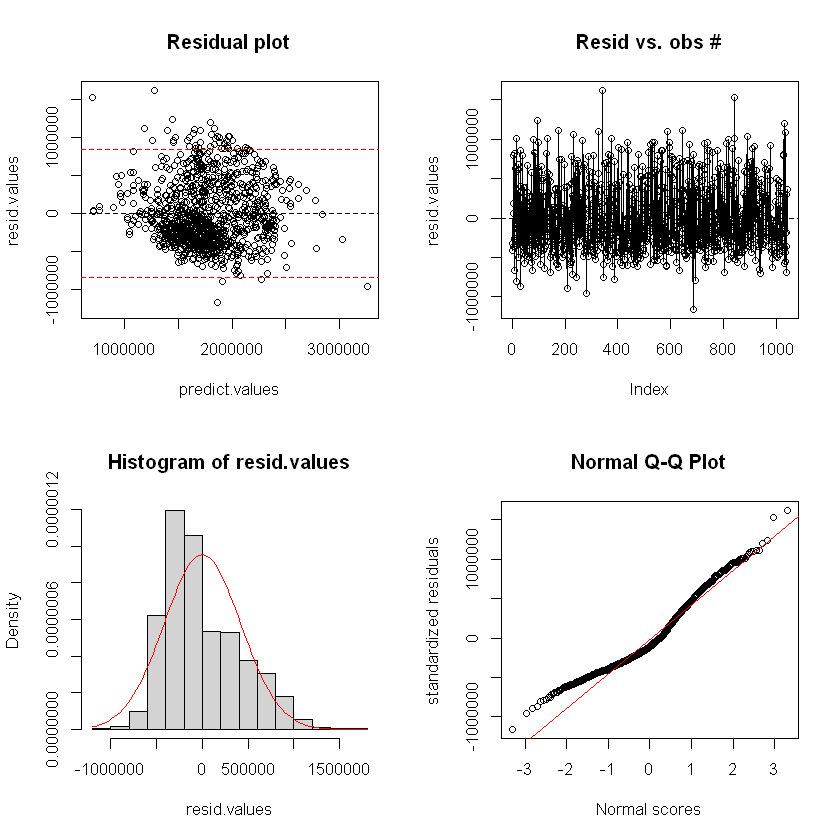

In [26]:
# Check assumptions of linearity, equal variance, normality here.
checkresiduals(z)
# Comment on any unusual observations (outliers) that are observed.

**Check assumptions of linearity, equal variance, normality here.**
* Linearity: According to the residual plot, we can observe that the model is relatively linear with an exception of clusters on the lower left corner. 
* Equal Variance: In terms of variance, there is a noticeable trend on the residual plot, showing that there is not much variance. 
* Normality: From the right skewed histogram and inaligned plots on the QQ-plot, we can assume that our model is not 100% normal. 

**Comment on any unusual observations (outliers) that are observed.**

I do observe some outliers in the plots. In the top left corner of the residual plot, there are several points locating above the upper red dotted lines. The same points can also be observed in the histogram and the Q-Q plot. In the histogram, the x-axis ticks are extended more on the larger value bcecause there are more points with higher positive residual values, especially around the value 12,500,000. The normal Q-Q plot, on the other hand, shows that the points in the lower normal scores deviate from the red line. With the usual observations in the data, I cannot 100% assume that the model has satisfied every assumption. 


**Describe how the assumption of independence could be violated for this dataset in relation to space. 

Given the data for Vancouver city, the assumption of independence might be affected by their spaces or locations. Sellers will usually set their properties’ prices based on the benchmark of their neighborhoods. When sellers notice the housing price in the neighborhood is going up, they are highly likely to increase their prices to maximize their profits from the properties. The situation can be observed in the given data set. With similar age, lot size, and total floor area, houses in Dunbar can reach \\$3,000K while houses in east Vancouver can be \\$700K. The reason behind this may also be related to the public utilities of neighborhoods and the number of crime events. Every factor related to the neighborhood but not in the data set will affect the accuracy rate of the prediction model. With the reasons above, the space, location, and neighborhood of a house in Vancouver city may be a potential factor for violating the assumption of independence in the model.


---
## Goodness of fit to the training set.
Find the R2 value and the residual standard error.

In [27]:
prediction <- predict(z)
residuals <- resid(z)

SSY <- sum((mydata.train$Price - mean(mydata.train$Price))^2)
SSE <- sum((mydata.train$Price - prediction)^2)
SSreg <- sum((prediction - mean(mydata.train$Price))^2)

# R squared value
R2 <- (SSY - SSE)/SSY;R2
# Residual standard error.
Se <- sqrt(SSE/(nrow(mydata.train)-2-1)); Se

[1] 0.394816

[1] 419271.1

---
## Do you have any concerns about the explanatory variables being related to each other? 

Show plots and/or do analyses to support your conclusions. If there are associations between explanatory variables, what effect could this have on the model? How would this affect the predictions?  

           Total.sqrt Lot.sqrt Age.log
Total.sqrt       1.00     0.41   -0.39
Lot.sqrt         0.41     1.00    0.06
Age.log         -0.39     0.06    1.00

n= 1042 


P
           Total.sqrt Lot.sqrt Age.log
Total.sqrt            0.0000   0.0000 
Lot.sqrt   0.0000              0.0401 
Age.log    0.0000     0.0401          

Total.sqrt   Lot.sqrt    Age.log 
  1.528242   1.295327   1.276902

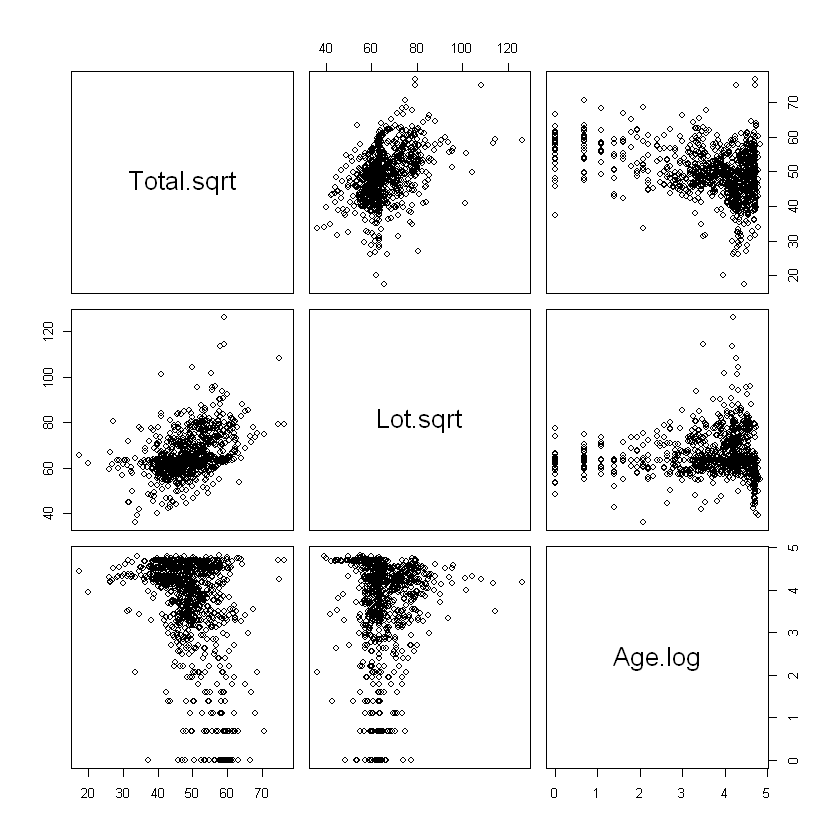

In [39]:
# select the x variables in the final model to be a subset of mydata.train
mydata.x.variables <- subset(mydata.train, select = c('Total.sqrt','Lot.sqrt', 'Age.log') )
# use plot(), rcorr() to show the relationships of explanatroy variables
plot(mydata.x.variables)
rcorr(as.matrix(mydata.x.variables))
# use vif() to check if the relationships of explanatroy variables would affect the prediction
vif(lm(Price ~ Total.sqrt + Lot.sqrt + Age.log, data = mydata.train))

**Show plots and/or do analyses to support your conclusions. If there are associations between explanatory variables, what effect could this have on your model? How would this affect your predictions?**

Based on the scatter plots between variables, there is no clear trend in the graph of the square root of Total Floor Area and the log of Age, which means these two variables have no obvious association with each other.

However, the other two graphs show potential association but can be rejected by the VIF (Variance Inflation Factor) value. There is a cluster in the graph of the square root of Total Floor Area and the square of Lot Size. The potential reason might be that a property can be built larger with a larger lot size. On the other hand, there is an exponential or log trend in the graph of the square root of Lot Size and the log of Age.

The VIF values of the square root of Total Floor Area, the square of Lot Size, and the log of Age are 1.53, 1.3, and 1.28 respectively. In general, VIF > 5 indicates moderate multicollinearity, while VIF > 10 indicates strong multicollinearity that is influencing the estimates. Given the benchmark, the three variables are all weak multicollinearity, so I do not need to be concerned about those variables being related to each other too much based on the given data 

---
<a id="Hyp_tests"></a>
## Hypothesis tests

Conduct an F-test for the significance of the regression and t-tests for the significance of each variable.  
Write the concluding sentence for each hypothesis test, then in brackets include the test statistic and a p-value). Use alpha = 0.05 to make all decisions for this project.  
E.g.: The variable log baha is significant in the final model (t statistic = 15.32, df error = 38, p-value < 0.0001).

What do these results tell you about the contribution of each variable to your final model?

In [29]:
# partial F test to test the interation of Lot.sqrt and Age.log
drop1(z,test='F')

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,182643964626124,26987.03,NA,NA
Total.sqrt,1,33448032738063,216091997364187,27160.26,189.908328,0.0000000000000000000000000000000000000008492404
Lot.sqrt:Age.log,1,1597128177923,184241092804046,26994.10,9.068035,0.0026641855856116567272118267339919839287176728


In [30]:
# F test to test the regression
anova(z)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Total.sqrt,1,99586867942983,99586867942983,565.425648,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000004200823
Lot.sqrt,1,10972963963258,10972963963258,62.301339,0.0000000000000074611049463576465663565417951730296408641152083873748779296875000000000000000000000000000000
Age.log,1,6998155793565,6998155793565,39.733520,0.0000000004298235299494560890214145398857681357185356318950653076171875000000000000000000000000000000000000
Lot.sqrt:Age.log,1,1597128177923,1597128177923,9.068035,0.0026641855856118197912185685538588586496189236640930175781250000000000000000000000000000000000000000000000
Residuals,1037,182643964626124,176127256149,NA,NA


In [31]:
# t test to test the variable Total.sqrt
summary(z)
alpha <- 0.05
f.crit <- qf(1-alpha, 5, 1042 - 6); f.crit
t.crit <- qt(1-alpha/2, 1042 - 6); t.crit


Call:
lm(formula = Price ~ Total.sqrt + Lot.sqrt + Age.log + Lot.sqrt * 
    Age.log, data = mydata.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1160293  -307411  -108056   282733  1618803 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)        907155     460479   1.970             0.049101 *  
Total.sqrt          32086       2328  13.781 < 0.0000000000000002 ***
Lot.sqrt            -7292       7692  -0.948             0.343392    
Age.log           -423895     114779  -3.693             0.000233 ***
Lot.sqrt:Age.log     5507       1829   3.011             0.002664 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 419700 on 1037 degrees of freedom
Multiple R-squared:  0.3948,	Adjusted R-squared:  0.3925 
F-statistic: 169.1 on 4 and 1037 DF,  p-value: < 0.00000000000000022


[1] 2.222741

[1] 1.962256

* The variable Total.sqrt is significant in the final model (t statistic = 13.781, df error = 1037, p-value < 0.0001).

* The interaction variable Lot.sqrt:Age.log is significant in the final model (t statistic = 3.011, df error = 1037, p-value < 0.01).

* The regression is significant in the final model (f statistic = 169.1, df error = 1037, p-value < 0.0001)

Because both the main and interaction variables have low p-values, the model rejects the null hypothesis and the confidence is sufficient to support the alternative hypothesis that the variables are significant. 

The square root of Total Floor Area, the square root of Lot Size, and the log of Age will have main effect on the price. 

If the square root of Total Floor Area increase by 1, the price will increase by $32,086.

When I decrease the square root of Lot Size and the log of Age variables by 1 simultaneously, I will increase the price value by $425,680. 

The interaction between Lot Size and Age will contribute to the price, which means the square root of Lot Size and the log of Age have an interaction effect on the Price simultaneously.


---
<a id="Prediction"></a>
## Using the model for prediction

Generate predicted values using the **validation set data** as input in the final model. Make sure that you are still using the model that was fit to the training set data, and only using the test set data as new x-values.

Calculate the mean absolute error (MAE) and root mean squared error (root MSE) for the validation set.
If you transformed the y-variable, get predicted values back in the original units prior to calculating these.

In [32]:
mydata.valid$Age.log <- log(mydata.valid$Age + 1)
mydata.valid$Total.sqrt <- sqrt(mydata.valid$Total.floor.area)
mydata.valid$Lot.sqrt <- sqrt(mydata.valid$Lot.Size)

mydata.valid$prediction <- predict(z, newdata = mydata.valid)
mydata.valid$error <- mydata.valid$Price - mydata.valid$prediction

RMSE <- sqrt(sum(mydata.valid$error^2)/nrow(mydata.valid));RMSE
MAE <- sum(abs(mydata.valid$error))/nrow(mydata.valid);MAE

[1] 431355.8

[1] 356162.7

---
<a id="Compare"></a>
## Comparing to other candidate models
**Compare the MAE and root MSE (for the validation set) from your final model to these values for at least two other candidate models (include the code for these models at the end of this notebook). If you transformed the y-variable, get predicted values back in the original units prior to calculating these.**

Compare the MAE and root MSE (for the validation set) from your final model to these values for at least two other candidate models (include the code for these models at the end of this notebook). If you transformed the y-variable, get predicted values back in the original units prior to calculating these.

**Write the model statement**  

| Model | MAE | root MSE | model statement|
|------|------|------|------|
| Final model | 431355.839722713 | 356162.718509518 | Price ~ Total.sqrt + Lot.sqrt + Age.log + Lot.sqrt*Age.log |
| Model A | 452223.461059616 | 369069.211938679 | Price ~ Total.floor.area + Lot.Size + Age |
| Model B | 449070.041245735 | 376258.911249469 | Price ~ Total.log + Lot.log + Age |
| Model C | 446768.036519619 | 365479.205848506 | Price ~ Total.floor.area + Lot.Size + Age.sqrt |

---
<a id="Transformations"></a>
# Visualizing appropriate transformations


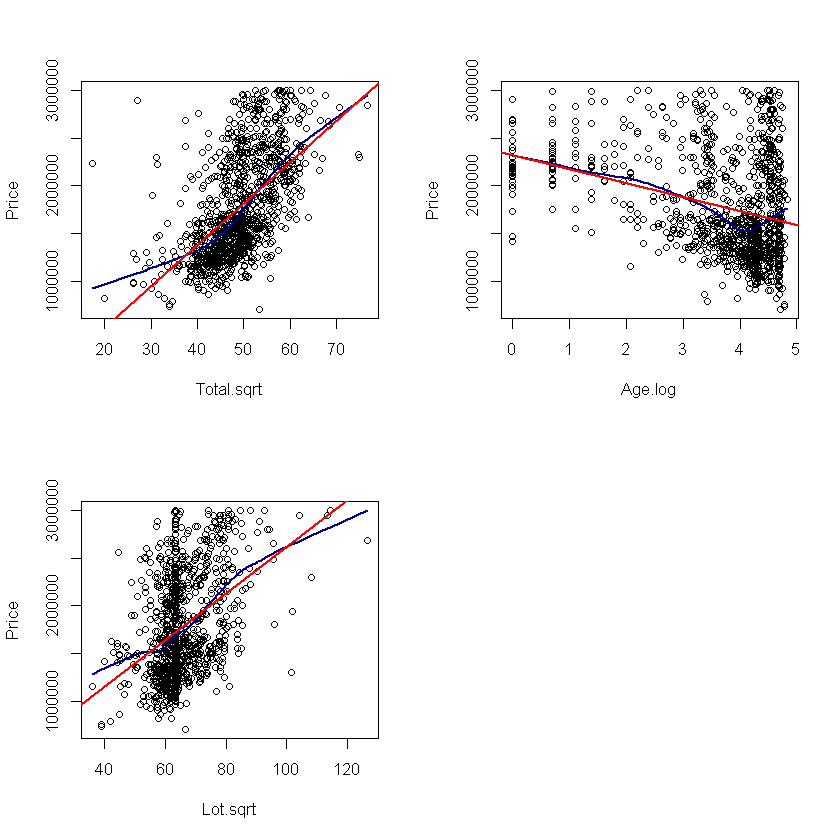

In [33]:
# Include the code for visualizing appropriate transformations of the variables here
par(mfrow=c(2,2))

plot(Price ~ Total.sqrt, data = mydata.train)
lines(lowess(mydata.train$Total.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zTsqrt <- lm(Price ~ Total.sqrt, data = mydata.train)
abline(zTsqrt, col="red", lwd = 2)

plot(Price ~ Age.log, data = mydata.train)
lines(lowess(mydata.train$Age.log, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zAlog <- lm(Price ~ Age.log, data = mydata.train)
abline(zAlog, col="red", lwd = 2)

plot(Price ~ Lot.sqrt, data = mydata.train)
lines(lowess(mydata.train$Lot.sqrt, mydata.train$Price, delta = 0.1), col="blue4", lwd = 2)
zLsqrt <- lm(Price ~ Lot.sqrt, data = mydata.train)
abline(zLsqrt, col="red", lwd = 2)

---
<a id="Other_models"></a>
# Other candidate models

In [34]:
# Include the code for other candidate models here.

# Do transformations in mydata.valid.
mydata.valid$Days.log <- log(mydata.valid$Days.on.market + 1)
mydata.valid$Days.sqrt <- sqrt(mydata.valid$Days.on.market + 1)
mydata.valid$Days.sq <- (mydata.valid$Days.on.market + 1)^2

mydata.valid$Total.log <- log(mydata.valid$Total.floor.area)
mydata.valid$Total.sqrt <- sqrt(mydata.valid$Total.floor.area)
mydata.valid$Total.sq <- (mydata.valid$Total.floor.area)^2

mydata.valid$Age.log <- log(mydata.valid$Age + 1)
mydata.valid$Age.sqrt <- sqrt(mydata.valid$Age + 1)
mydata.valid$Age.sq <- (mydata.valid$Age + 1)^2

mydata.valid$Lot.log <- log(mydata.valid$Lot.Size)
mydata.valid$Lot.sqrt <- sqrt(mydata.valid$Lot.Size)
mydata.valid$Lot.sq <- (mydata.valid$Lot.Size)^2

In [35]:
# Create one function to test every candidate model
# input: model statement
# output: a list of R2, Se, RMSE, MAE, AIC, and the model statement
linear_regression <- function(formula){
    z <- lm(formula, data = mydata.train)
    #print(summary(z))
    #print(anova(z))
    #print(checkresiduals(z))
    #print(shapiro.test(resid(z)))
    
    #Calculate the goodness of fit:
    mydata.train$prediction <- predict(z)
    mydata.train$residuals <- resid(z)
    SSY <- sum((mydata.train$Price - mean(mydata.train$Price))^2)
    SSE <- sum((mydata.train$Price - mydata.train$prediction)^2)
    SSreg <- sum((mydata.train$prediction - mean(mydata.train$Price))^2)
    R2 <- (SSY - SSE)/SSY
    Se <- sqrt(SSE/(nrow(mydata.train)-2-1))
    
    # test valid data
    mydata.valid$prediction <- predict(z, newdata = mydata.valid)
    RMSE <- sqrt(sum((mydata.valid$Price - mydata.valid$prediction)^2)/nrow(mydata.valid))
    MAE <- sum(abs(mydata.valid$Price - mydata.valid$prediction))/nrow(mydata.valid)
    
    F.crit <- qf(0.95, length(coefficients(z))-1,1042-length(coefficients(z)))
    T.crit <- qt(0.975, 1042 - length(coefficients(z)))
    
    AIC <- AIC(z)
    
    table <- c(R2, Se, RMSE, MAE, AIC, toString(formula[3]))
    return(table)

}

In [36]:
# set candidate models
z1 <- Price ~ Total.floor.area + Lot.Size
z2 <- Price ~ Total.sq + Lot.sq
z3 <- Price ~ Total.log + Lot.log
z4 <- Price ~ Total.sqrt + Lot.sqrt

z5 <- Price ~ Total.floor.area + Lot.Size + Age
z6 <- Price ~ Total.sq + Lot.sq + Age
z7 <- Price ~ Total.log + Lot.log + Age
z8 <- Price ~ Total.sqrt + Lot.sqrt + Age

z9 <- Price ~ Total.floor.area + Lot.Size + Age.log
z10 <- Price ~ Total.sq + Lot.sq + Age.log
z11 <- Price ~ Total.log + Lot.log + Age.log
z12 <- Price ~ Total.sqrt + Lot.sqrt + Age.log

z13 <- Price ~ Total.floor.area + Lot.Size + Age.sqrt
z14 <- Price ~ Total.sq + Lot.sq + Age.sqrt
z15 <- Price ~ Total.log + Lot.log + Age.sqrt
z16 <- Price ~ Total.sqrt + Lot.sqrt + Age.sqrt

z17 <- Price ~ Total.floor.area + Lot.Size + Age.sq
z18 <- Price ~ Total.sq + Lot.sq + Age.sq
z19 <- Price ~ Total.log + Lot.log + Age.sq
z20 <- Price ~ Total.sqrt + Lot.sqrt + Age.sq

In [37]:
# use the linear_regression function to get results
r1 <- linear_regression(z1)
r2 <- linear_regression(z2)
r3 <- linear_regression(z3)
r4 <- linear_regression(z4)
r5 <- linear_regression(z5)
r6 <- linear_regression(z6)
r7 <- linear_regression(z7)
r8 <- linear_regression(z8)
r9 <- linear_regression(z9)
r10 <- linear_regression(z10)
r11 <- linear_regression(z11)
r12 <- linear_regression(z12)
r13 <- linear_regression(z13)
r14 <- linear_regression(z14)
r15 <- linear_regression(z15)
r16 <- linear_regression(z16)
r17 <- linear_regression(z17)
r18 <- linear_regression(z18)
r19 <- linear_regression(z19)
r20 <- linear_regression(z20)

In [38]:
# create a table to compare results
mx <- rbind(r1,r2,r3,r4,r5,r6,r7,r8,r9, r10, r11,r12,r13,r14,r15,r16, r17,r18,r19,r20)
colnames(mx) <- c('R2', 'Se', 'RMSE', 'MAE', 'AIC', 'Formula')
df <- as.data.frame(mx)
df

,R2,Se,RMSE,MAE,AIC,Formula
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
r1,0.374745084769935,426166.923715408,458777.948202427,370457.840469517,29976.0936093029,Total.floor.area + Lot.Size
r2,0.350178809489694,434458.318593089,484556.303118605,384428.843743102,30016.249999583,Total.sq + Lot.sq
r3,0.340144444998748,437799.862604559,455997.177878325,380012.546452833,30032.2173173722,Total.log + Lot.log
r4,0.366335880552259,429023.163118738,454051.74788843,371920.298531598,29990.014315684,Total.sqrt + Lot.sqrt
r5,0.380958439131264,424044.159657469,452223.461059616,369069.211938679,29967.6871359561,Total.floor.area + Lot.Size + Age
r6,0.358837236527966,431554.180884232,475500.882413496,382236.059555802,30004.2727286401,Total.sq + Lot.sq + Age
r7,0.34838141853884,435058.754701642,449070.041245735,376258.911249469,30021.1281697479,Total.log + Lot.log + Age
r8,0.372785424859026,426834.242650356,447740.385454643,370071.599980356,29981.3543151471,Total.sqrt + Lot.sqrt + Age
r9,0.394805875562188,419274.581243676,441689.670562888,360162.476545686,29944.1138251389,Total.floor.area + Lot.Size + Age.log
